### Importing the necessary libraries

Please make sure that, before proceeding further, to have `elasticsearch` docker container running - this is a dependancy that would be used throughout the walkthrough.

Following is the workflow of our process of retrieving documents using semantic search:

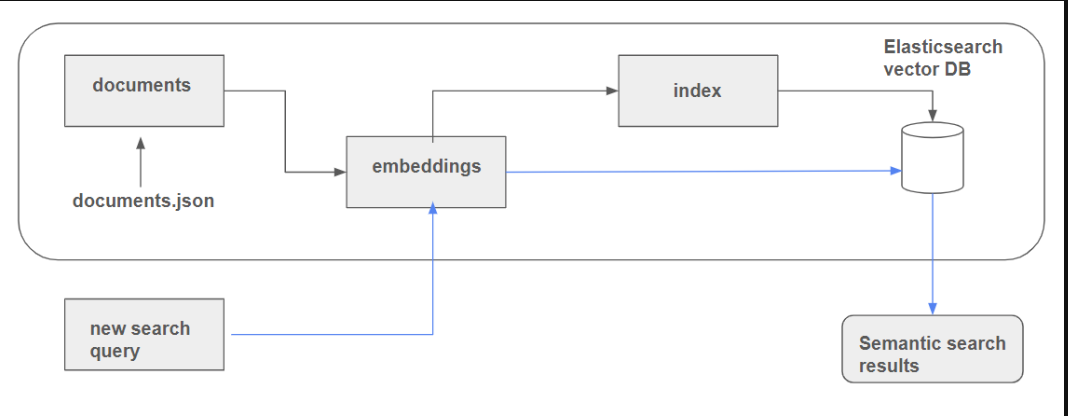

In [1]:
from elasticsearch import Elasticsearch
from sentence_transformers import SentenceTransformer
import json
import warnings

warnings.filterwarnings('ignore')


/home/codespace/.python/current/lib/python3.12/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


### Data Loading and Preprocessing

In [2]:
!rm documents.json
!wget https://raw.githubusercontent.com/DataTalksClub/llm-zoomcamp/main/01-intro/documents.json

--2024-09-20 03:05:06--  https://raw.githubusercontent.com/DataTalksClub/llm-zoomcamp/main/01-intro/documents.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 658332 (643K) [text/plain]
Saving to: ‘documents.json’

documents.json      100%[===================>] 642.90K  --.-KB/s    in 0.01s   

2024-09-20 03:05:06 (61.0 MB/s) - ‘documents.json’ saved [658332/658332]



In [3]:
# we downloaded the data in the previous cell - here we want to load the JSON object in python by using the json module
# to load it as a python object (in our case its a python dictionary)

with open('documents.json', 'rt') as file:
    docs_raw = json.load(file)

In [4]:
# now to flatten our list of dictionaries - our only preprocessing step

documents = [{'course':course_dict['course'],'section':doc['section'],'question':doc['question'],'text':doc['text']} \
            for course_dict in docs_raw \
            for doc in course_dict['documents']]

documents[0]

{'course': 'data-engineering-zoomcamp',
 'section': 'General course-related questions',
 'question': 'Course - When will the course start?',
 'text': "The purpose of this document is to capture frequently asked technical questions\nThe exact day and hour of the course will be 15th Jan 2024 at 17h00. The course will start with the first  “Office Hours'' live.1\nSubscribe to course public Google Calendar (it works from Desktop only).\nRegister before the course starts using this link.\nJoin the course Telegram channel with announcements.\nDon’t forget to register in DataTalks.Club's Slack and join the channel."}

### Transform into Embeddings

In [5]:
# Load a pretrained sentence transformer model

model = SentenceTransformer("all-mpnet-base-v2") # best pretrained model in their library

In [6]:
# next we are going to create embeddings on the text field (dense vectors) - `or doc` needs to be included in update method
# this ensures that original doc is returned after the update

documents = [doc.update({'text_vector': model.encode(doc['text']).tolist()}) or doc for doc in documents]

### Initiallising the ElasticSearch Connection

In [7]:
# establishing the connection with ElasticSearch

es_client = Elasticsearch("http://localhost:9200")

es_client.info()

ObjectApiResponse({'name': '13bd0d54f376', 'cluster_name': 'docker-cluster', 'cluster_uuid': 'X0XqmKMbRmq-qYWr8uNUqA', 'version': {'number': '8.4.3', 'build_flavor': 'default', 'build_type': 'docker', 'build_hash': '42f05b9372a9a4a470db3b52817899b99a76ee73', 'build_date': '2022-10-04T07:17:24.662462378Z', 'build_snapshot': False, 'lucene_version': '9.3.0', 'minimum_wire_compatibility_version': '7.17.0', 'minimum_index_compatibility_version': '7.0.0'}, 'tagline': 'You Know, for Search'})

In [8]:
# we are checking to see the names of the indices that were created

indices = es_client.indices.get_alias(index="*")

for index in indices:
    print(index)

### Adding the documents to Index

1. Check the existing indices before creation of new index
2. Defining the schema of the newly created index - index settings and mapping
3. Creation of new index
4. Populating the index using the operations variable

In [9]:
#  next we want to create a mapping index

index_settings = {
    "settings" : {
        "number_of_shards" : 1,
        "number_of_replicas" : 0
    },

    "mappings" : {
        "properties" : {
            "course" : {"type":"text"},
            "section" : {"type":"text"},
            "question" : {"type":"text"},
            "text" : {"type":"text"},
            "text_vector" : {"type":"dense_vector",
                             "dims":768,
                             "index":True,
                             "similarity":"cosine"},
        }
    }
}

In [10]:
# now to proceed to create the index with index name and mappings as parameters for creation

index_name = "course-faqs"

if es_client.indices.exists(index=index_name):
    es_client.indices.delete(index=index_name, ignore_unavailable=True)
else:
    es_client.indices.create(index=index_name, body=index_settings)

In [11]:
# lastly to populate the index with our documents list using the bulk method instead of the conventional create method

index = {"index": {
    "_index":index_name
}}


operations =  [item for doc in documents for item in (index, doc)]

# here we use the bulk method to populate the index - we want to alternate between index and doc in line with the format provided by elastic search
# https://www.elastic.co/guide/en/elasticsearch/reference/current/getting-started.html 
# list comprehension breakdown - for each doc in documents, we append the unpacked item in tuple (index, doc) to our list [].
resp = es_client.bulk(operations = operations, timeout="120s")

In [12]:
if es_client.ping():
    print("Connected to Elasticsearch")
else:
    print("Could not connect to Elasticsearch")

Connected to Elasticsearch


In [18]:
# response confirmations that the index was populated with no errors

# print(resp)

### Create end user query and perform semantic search

In [14]:
# Here we will use the search term that was used in the course - again we need to convert our serch term into an embedding

search_term = 'Windows or Mac?'

vector_search_term = model.encode(search_term)

In [15]:
# we need to define the parameters of our query, that includes our search term vector as well

knn_query = {
    "field" : "text_vector",  # the field in which the search term should be queried
    "query_vector" : vector_search_term,  # the embedding of our search term
    "k" : 5,  # the number of nearest documents to be retrieved that matches the search term 
    "num_candidates" : 10000 # group of documents the search is going to look into
}

In [16]:
# running our semantic search with a filter in place - `match` is used as a filter field

response = es_client.search(
    index=index_name,
    query={
        "match" : {"section": "General course-related questions"},
    },
    knn=knn_query,
    size=5
)

In [17]:
# document with the highest similarity score - hence best response to query

response["hits"]["hits"][0]['_source']['text']

'Yes! Linux is ideal but technically it should not matter. Students last year used all 3 OSes successfully'